In [15]:
%load_ext autoreload
%autoreload 2

In [225]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('poster')
sns.set_color_codes()

In [226]:
import clumpy
from clumpy import datasets

### 10k Diabetes Processing
- Numerics: Center and Scale
- Categoricals: Remove categoricals with < 2 levels, Add a level for missing values, One-Hot Encode

In [236]:
diabetes = datasets.fetch_10kdiabetes()
diabetes.as_raw().head(10)

[autoreload of clumpy failed: Traceback (most recent call last):
  File "/home/joshua/.virtualenvs/plot/local/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name base
]


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1.0,CP,Surgery-Neuro,...,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2.0,UN,?,...,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7.0,MC,Family/GeneralPractice,...,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4.0,UN,?,...,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5.0,?,Psychiatry,...,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis
5,Caucasian,Male,[70-80),?,Elective,Discharged to home,Physician Referral,4.0,?,Cardiology,...,No,No,No,No,No,Yes,False,"Congestive heart failure, unspecified",Paroxysmal supraventricular tachycardia,Coronary atherosclerosis of unspecified type o...
6,Caucasian,Female,[60-70),?,Elective,Expired,Physician Referral,6.0,MC,InternalMedicine,...,No,No,No,No,No,Yes,False,Cerebral thrombosis without mention of cerebra...,"Generalized nonconvulsive epilepsy, without me...",Acute kidney failure
7,Caucasian,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,2.0,?,?,...,No,No,No,No,No,Yes,False,Other and unspecified noninfectious gastroente...,Diverticulosis of small intestine (without men...,Internal hemorrhoids without mention of compli...
8,Caucasian,Male,[50-60),?,NaN,Discharged to home,NaN,3.0,?,Family/GeneralPractice,...,No,No,No,No,No,No,False,"Congestive heart failure, unspecified",Endomyocardial fibrosis,Viral hepatitis A with hepatic coma
9,Caucasian,Male,[60-70),?,Elective,Discharged to home,Physician Referral,5.0,?,Surgery-Cardiovascular/Thoracic,...,No,No,No,No,No,Yes,True,Atherosclerosis of aorta,"Postoperative shock, unspecified","Postoperative shock, unspecified"


### Fit PCA and then TSNE to embed in 2D

In [237]:
from sklearn.decomposition import RandomizedPCA, TruncatedSVD

# center the data
X = diabetes.as_onehot().values
X -= np.mean(X, axis=0)
pca = TruncatedSVD(n_components=50, random_state=1234).fit_transform(X)

In [238]:
from sklearn.manifold import TSNE

scaled_pca = pca - np.mean(pca, axis=0)
scaled_pca /= np.max(scaled_pca, axis=0)
embedding = TSNE(n_components=2, random_state=1234, verbose=True).fit_transform(scaled_pca)
embedding -= np.mean(embedding, axis=0)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.508990
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.366781
[t-SNE] Error after 325 iterations: 1.366781


### Cluster using HDBSCAN

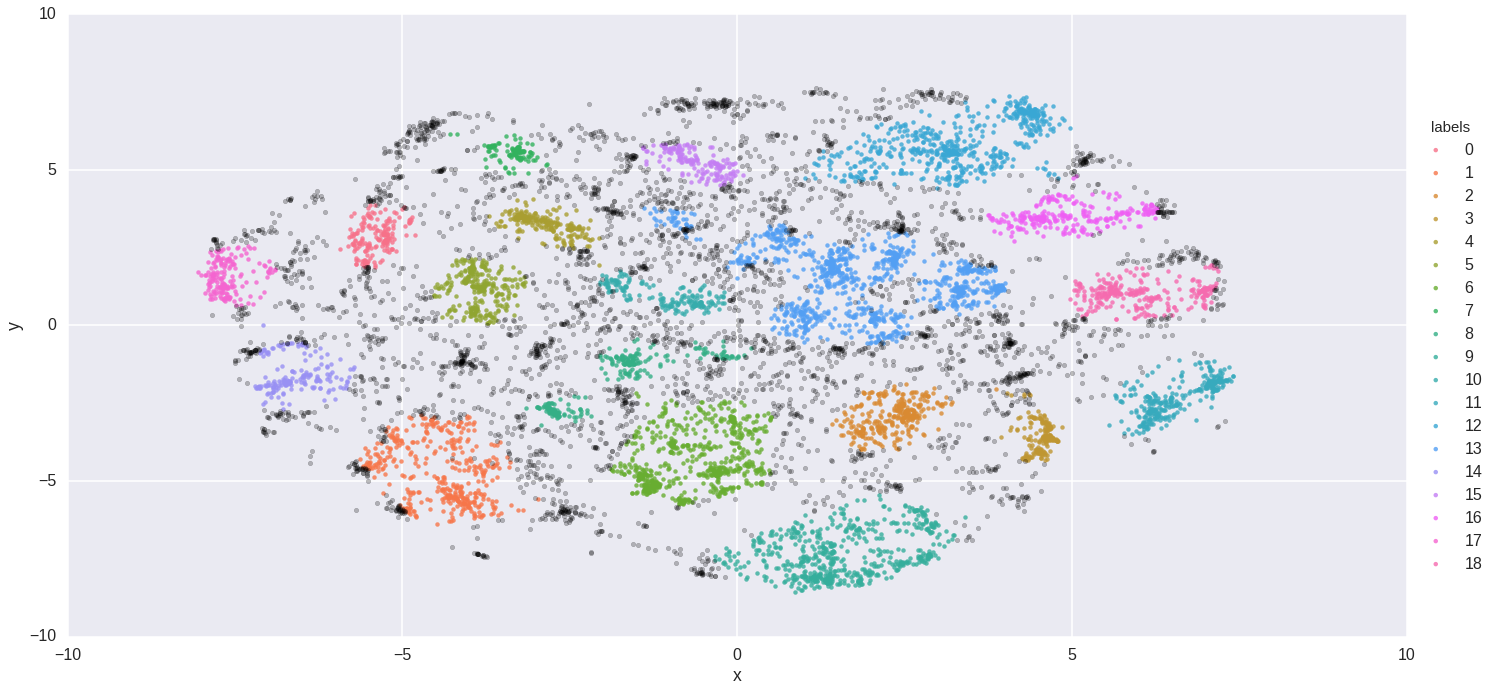

In [239]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=int(X.shape[0] * .01)).fit(embedding)
clumpy.plots.plot_clusters(embedding, clusterer.labels_)

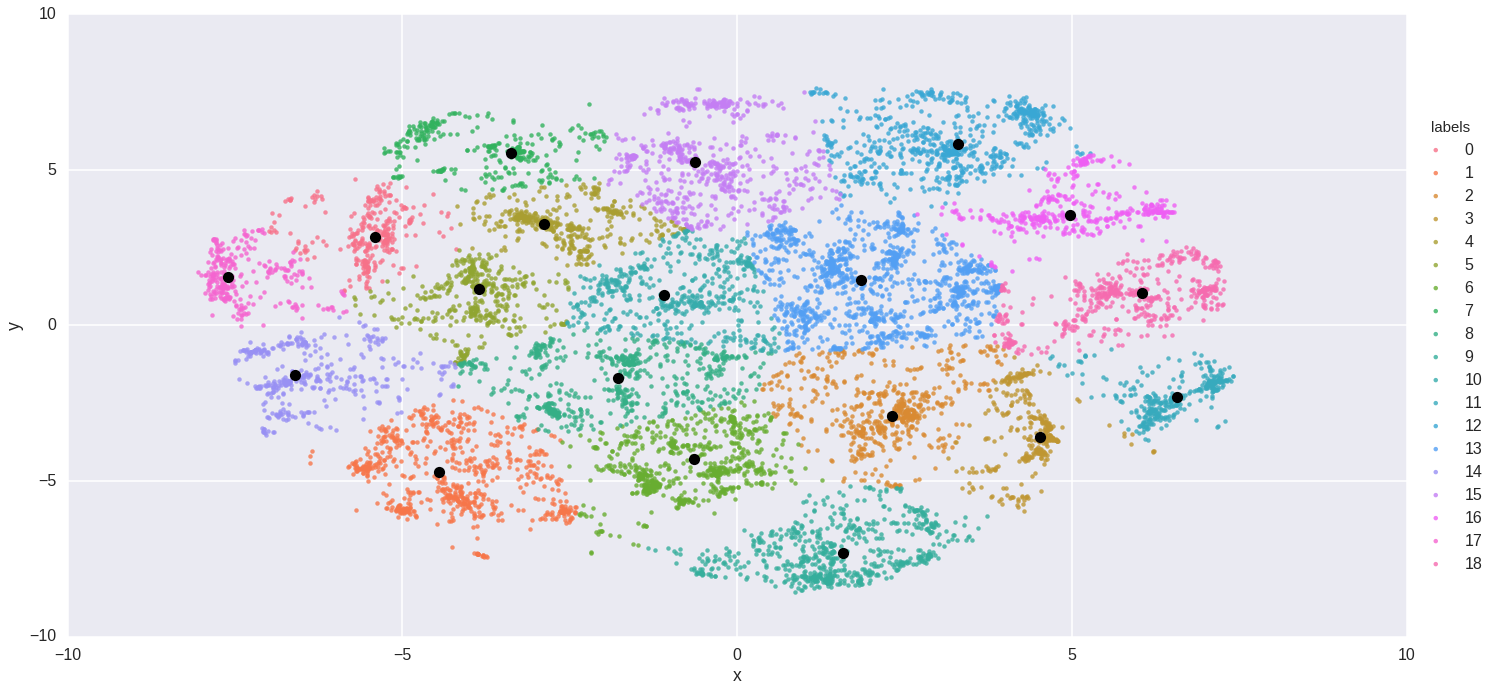

In [240]:
from clumpy.base import convert_to_kmeans

kmeans = convert_to_kmeans(embedding, clusterer)
clumpy.plots.plot_clusters(embedding, kmeans.labels_, kmeans.cluster_centers_)

In [253]:
from clumpy.summary import cluster_summary
summary = cluster_summary(diabetes.as_cleaned(), kmeans, bin_numeric=True)
summary

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide.metformin,glipizide.metformin,change,diabetesMed
cluster,,,,,,,,,,,,,,,,,,,,,
0,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
1,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
2,6,10,4,9,4,1,2,7,Caucasian,Male,...,No,Steady,No,No,No,No,No,No,Ch,Yes
3,6,10,4,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,Ch,Yes
4,6,10,4,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
5,6,10,5,9,4,1,2,7,Caucasian,Female,...,Steady,No,No,No,No,No,No,No,Ch,Yes
6,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
7,5,10,6,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
8,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,Ch,Yes


### Feature Importance

In [256]:
from clumpy.cluster_rules import ova_forest_importance

def cluster_name(summary, features):
    names = []
    for cluster_index in summary.index:       
        d = summary.loc[cluster_index]
        name =''
        fmt = '{var}={value}'
        for var in features[cluster_index]:
            name += fmt.format(var=var, value=d.loc[var])
            name += '; '
        names.append(name)
    return names

features = ova_forest_importance(diabetes.as_ordinal(), kmeans.labels_, columns=diabetes.as_cleaned().columns, top_k=3)
cluster_names = cluster_name(summary, features)

TypeError: list indices must be integers, not str

In [254]:
summary.index = cluster_names
summary

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide.metformin,glipizide.metformin,change,diabetesMed
num_medications=16.0; number_emergency=0.0; gender=Female;,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
number_outpatient=0.0; diag_3=250.0; diag_2=250.0;,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
rosiglitazone=Steady; diag_3=250.0; gender=Male;,6,10,4,9,4,1,2,7,Caucasian,Male,...,No,Steady,No,No,No,No,No,No,Ch,Yes
num_lab_procedures=41.0; diag_3=250.0; diag_2=648.0;,6,10,4,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,Ch,Yes
num_lab_procedures=45.0; number_outpatient=0.0; diag_3=250.0;,6,10,4,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
pioglitazone=Steady; gender=Female; diag_3=401.0;,6,10,5,9,4,1,2,7,Caucasian,Female,...,Steady,No,No,No,No,No,No,No,Ch,Yes
num_lab_procedures=44.0; diag_3=250.0; diag_2=401.0;,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
diag_1=414.0; diag_2=411.0; age=[60-70);,5,10,6,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
insulin=No; num_lab_procedures=47.0; gender=Female;,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,Ch,Yes
num_lab_procedures=42.0; diag_3=250.0; diag_2=250.0;,6,10,4,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
